<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телескоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [3]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [4]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [5]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [6]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [7]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

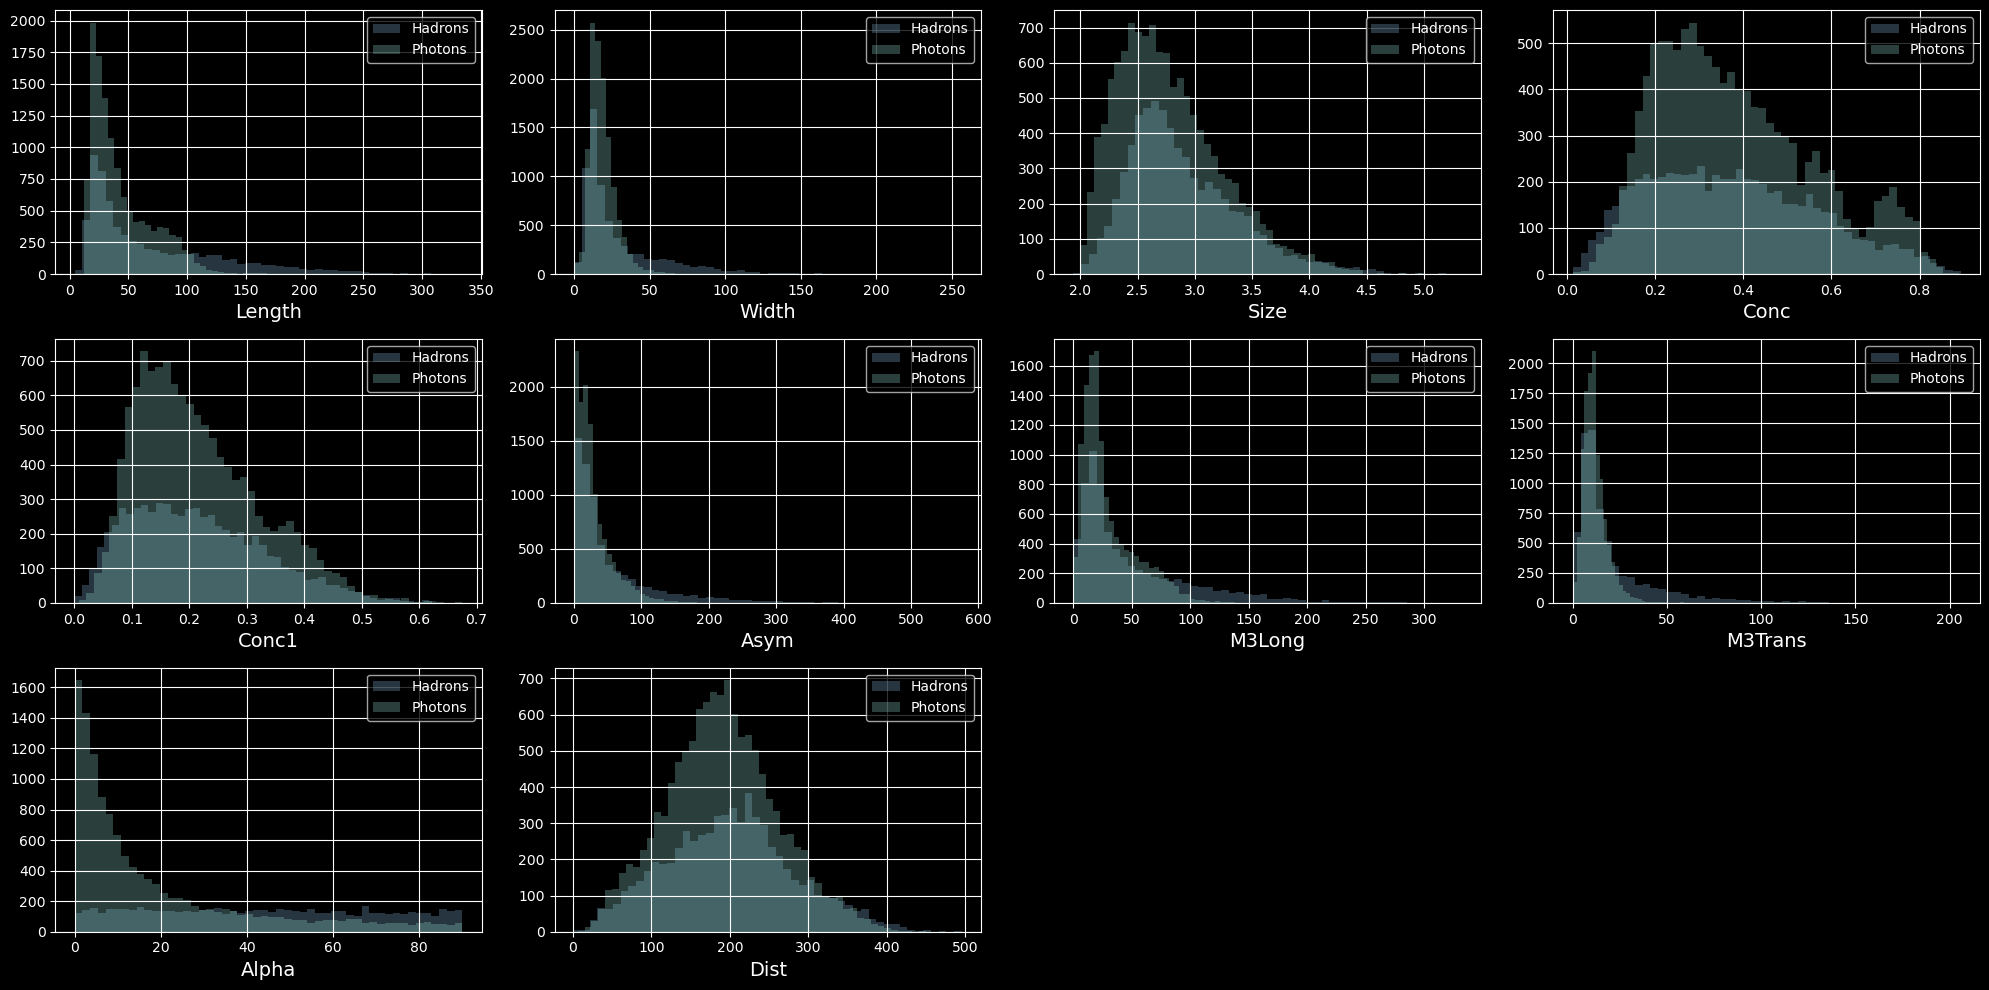

In [8]:
plot_hists(
    X[y[:, 0] == 0],
    X[y[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [9]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение целевой переменной внутри train и test выборки. Совпадает ли оно? Есть ли идеи почему так?

__Подсказка__: посмотрите на клеточку с разделением данных

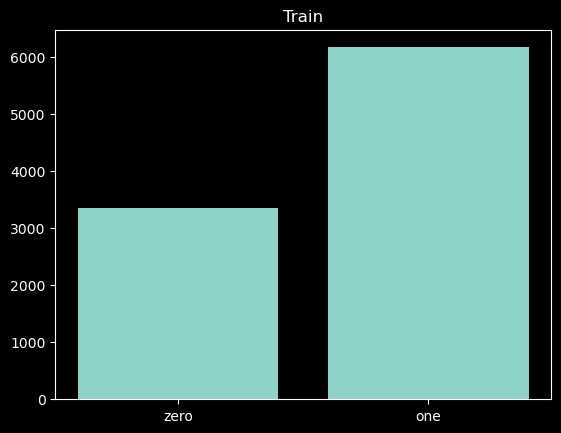

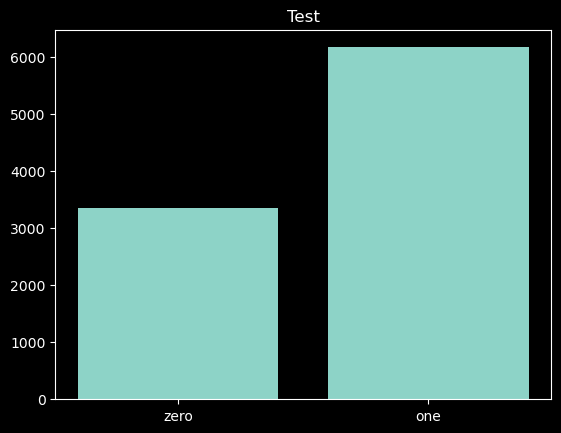

In [10]:
# y distribution
zero_train = (y_train == 0).sum()
one_train = (y_train == 1).sum()
zero_test = (y_test == 0).sum()
one_test = (y_test == 1).sum()

plt.bar(["zero", "one"], [zero_train, one_train])
plt.title("Train")
plt.show()
plt.bar(["zero", "one"], [zero_test, one_test])
plt.title("Test")
plt.show()


Оно совпадает, поскольку им указали параметер `stratify=y` при разбиении на train и test.

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [11]:
from sklearn.preprocessing import QuantileTransformer

quantile_transformer = QuantileTransformer(output_distribution="normal")


### YOUR CODE IS HERE ######
X_train = quantile_transformer.fit_transform(X_train)
X_test = quantile_transformer.transform(X_test)
### THE END OF YOUR CODE ###

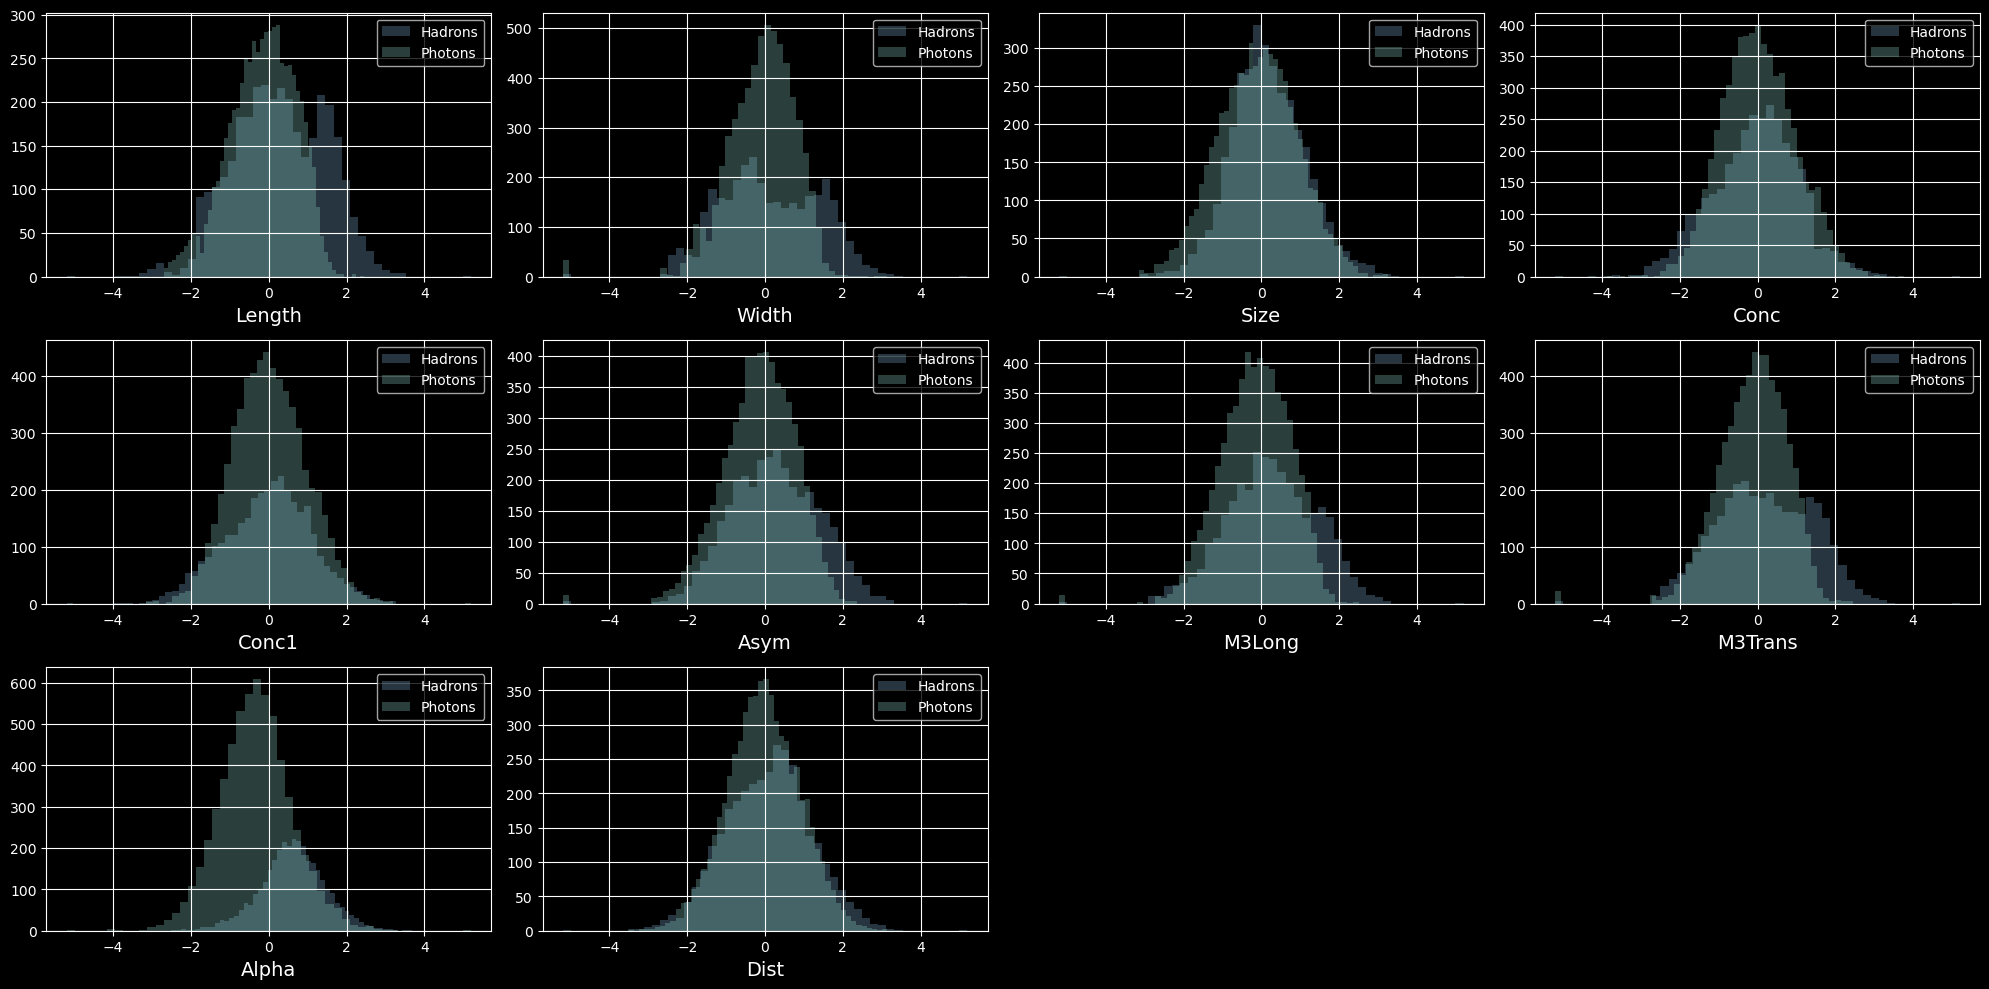

In [12]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

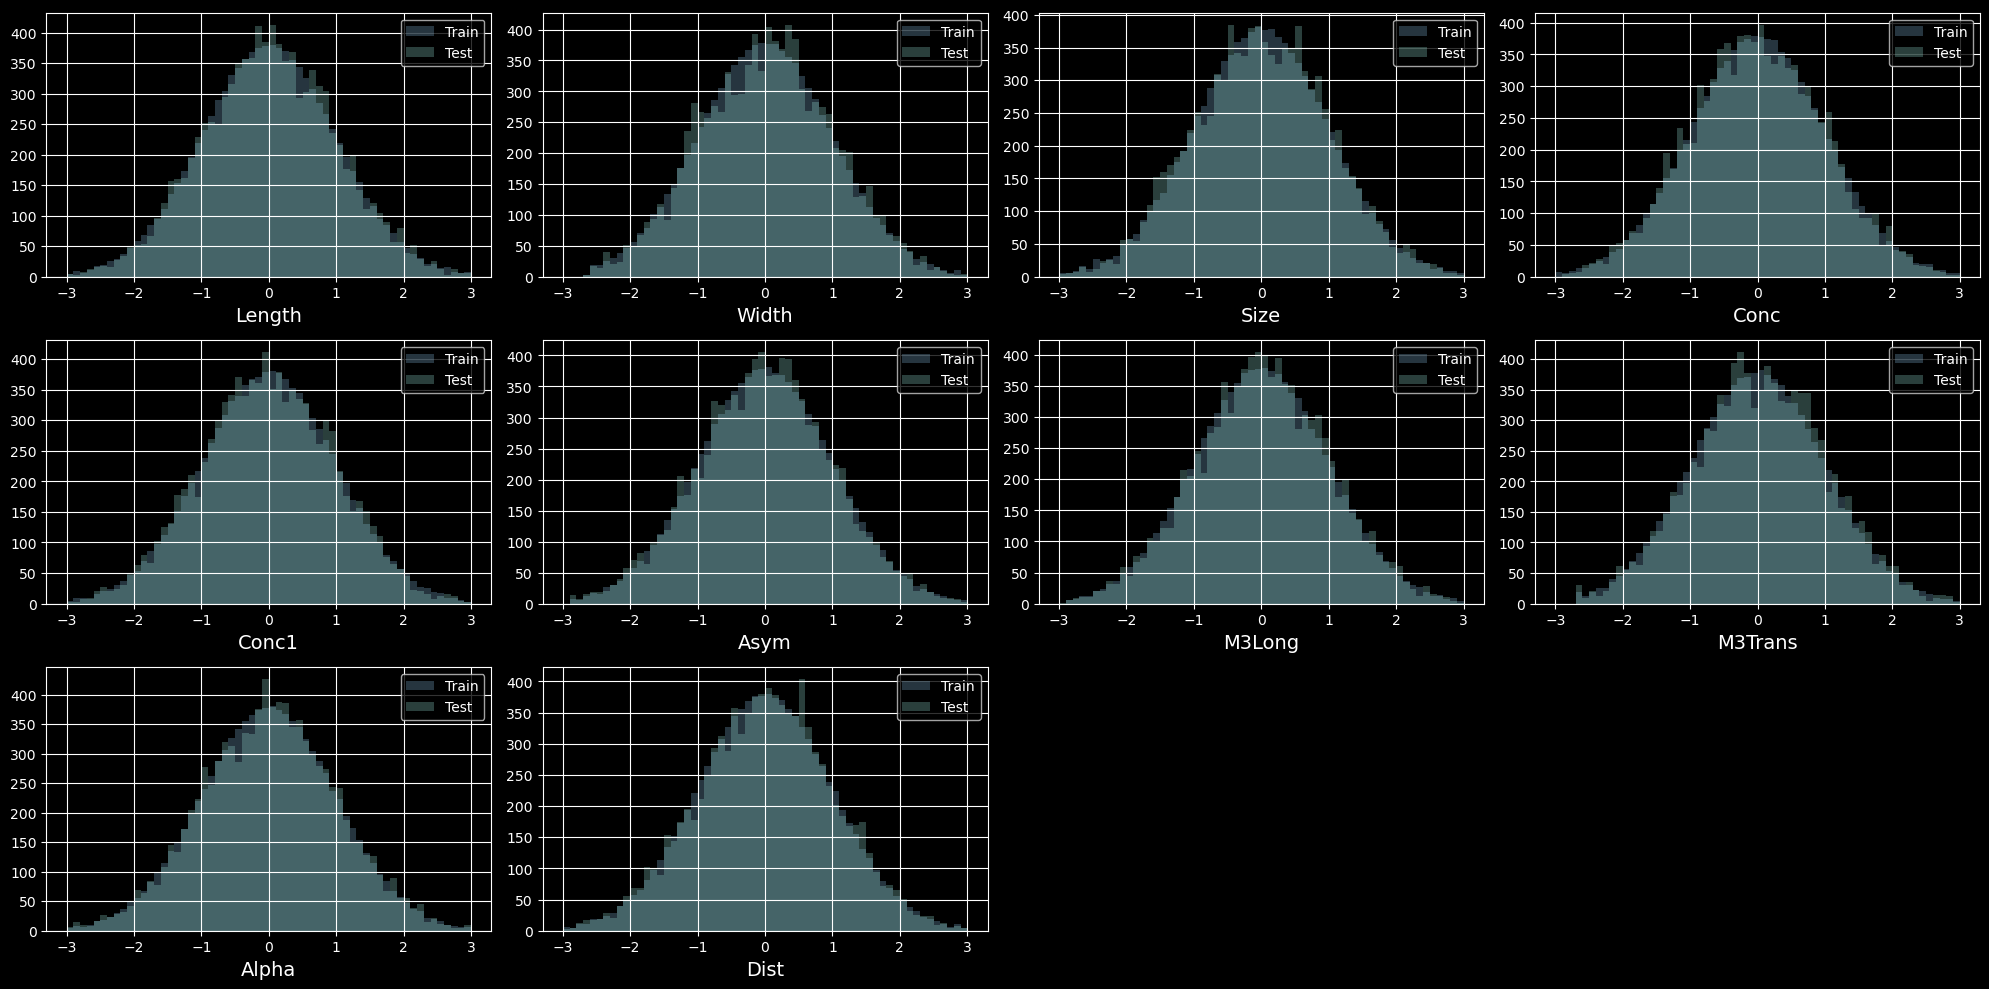

In [13]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + \frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

In [15]:
DEVICE

device(type='mps')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, dim: int):
        super(ResidualBlock, self).__init__()

        self.linear1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.linear2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)

    def forward(self, x):
        h = self.linear1(x)
        h = self.bn1(h)
        h = F.relu(h)
        h = self.linear2(h)
        h = self.bn2(h)
        return x + h


class Generator(nn.Module):
    def __init__(self, n_inputs: int, hidden_dim: int, n_outputs: int):
        super(Generator, self).__init__()

        self.linear1 = nn.Linear(n_inputs, hidden_dim)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim)
        self.blocks = nn.Sequential(
            *[ResidualBlock(hidden_dim) for _ in range(5)]
        )

        self.clf = nn.Linear(hidden_dim, n_outputs)

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)

        zy = self.linear1(zy)
        zy = self.batchnorm1(zy)
        zy = F.relu(zy)
        zy = self.blocks(zy)
        zy = self.clf(zy)
        return zy

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новых объектов $X$ по вектору условий $y$.

In [17]:
def generate(generator, y, latent_dim):

    z = torch.randn(len(y), latent_dim, device=DEVICE)
    X_fake = generator(z, y)

    return X_fake

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [18]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs: int, hidden_dim: int):
        super(Discriminator, self).__init__()

        self.linear1 = nn.Linear(n_inputs, hidden_dim)
        self.blocks = nn.Sequential(
            *[ResidualBlock(hidden_dim) for _ in range(1)]
        )
        self.clf = nn.Linear(hidden_dim, 1)

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        xy = self.linear1(xy)
        xy = F.relu(xy)
        xy = self.blocks(xy)
        xy = self.clf(xy)
        return xy

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier


def other_agent_score(X_real, y_real, X_fake, y_fake):
    # combine real and fake objects
    X = np.concatenate((X_real, X_fake), axis=0)
    y = np.concatenate((y_real, y_fake), axis=0)

    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    lin_reg = LogisticRegression()
    boosting = GradientBoostingClassifier()
    lin_reg_score = lin_reg.fit(X_train, y_train).score(X_test, y_test)
    boosting_score = boosting.fit(X_train, y_train).score(X_test, y_test)
    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [58]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=64,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(
            self.generator.parameters(), lr=self.lr
        )
        self.opt_disc = torch.optim.RMSprop(
            self.discriminator.parameters(), lr=self.lr
        )
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.opt_gen, T_max=self.n_epochs
        )

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            progress_bar = tqdm(
                DataLoader(
                    dataset_real, batch_size=self.batch_size, shuffle=True
                ),
                desc=f"Epoch {epoch + 1}/{self.n_epochs}",
            )
            for i, (real_batch, cond_batch) in enumerate(progress_bar):
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)

                # -- Discriminator update --
                for _ in range(self.n_critic):
                    fake_batch = generate(
                        self.generator, cond_batch, self.latent_dim
                    ).detach()
                    d_loss = -torch.mean(
                        self.discriminator(real_batch, cond_batch)
                    ) + torch.mean(self.discriminator(fake_batch, cond_batch))
                    d_loss.backward()
                    self.opt_disc.step()
                    self.opt_disc.zero_grad()
                    for param in self.discriminator.parameters():
                        param.data.clamp_(-0.01, 0.01)

                # -- Generator update --
                fake_batch = generate(
                    self.generator, cond_batch, self.latent_dim
                )
                g_loss = -torch.mean(self.discriminator(fake_batch, cond_batch))
                g_loss.backward()
                self.opt_gen.step()
                self.opt_gen.zero_grad()

                progress_bar.set_postfix(
                    d_loss=d_loss.item(),
                    g_loss=g_loss.item(),
                    lr=self.opt_gen.param_groups[0]["lr"],
                )

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(
                0, 1, (len(X_real), self.latent_dim), device=DEVICE
            )
            X_fake = self.generator(Z_noise, y_cond)

            loss_epoch = torch.mean(
                self.discriminator(X_real, y_cond)
            ) - torch.mean(self.discriminator(X_fake, y_cond))
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            # generate 1000 fake and 1000 real objects
            real_indices = np.random.choice(len(X_real), 1000, replace=False)
            X_fake = generate(
                self.generator, y_cond[real_indices], self.latent_dim
            )

            other_agent_score(
                X_real[real_indices].cpu().detach().numpy(),
                np.zeros(len(X_real[real_indices])),
                X_fake.cpu().detach().numpy(),
                np.ones(len(X_fake)),
            )

            self.scheduler.step()

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [60]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], hidden_dim=256, n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1], hidden_dim=64)

fitter = Fitter(
    generator,
    discriminator,
    batch_size=64,
    n_epochs=20,
    latent_dim=latent_dim,
    lr=3e-5,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Epoch 1/20: 100%|██████████| 149/149 [00:09<00:00, 15.35it/s, d_loss=0.00011, g_loss=-0.0193, lr=3e-5]  


Linear regression score: 0.5925
Boosting score: 0.745


Epoch 2/20: 100%|██████████| 149/149 [00:09<00:00, 16.09it/s, d_loss=0.000258, g_loss=-0.0206, lr=2.98e-5] 


Linear regression score: 0.4875
Boosting score: 0.7175


Epoch 3/20: 100%|██████████| 149/149 [00:08<00:00, 16.56it/s, d_loss=-0.000358, g_loss=-0.0214, lr=2.93e-5]


Linear regression score: 0.485
Boosting score: 0.625


Epoch 4/20: 100%|██████████| 149/149 [00:08<00:00, 16.62it/s, d_loss=-0.000173, g_loss=-0.0213, lr=2.84e-5]


Linear regression score: 0.495
Boosting score: 0.67


Epoch 5/20: 100%|██████████| 149/149 [00:08<00:00, 16.98it/s, d_loss=7.41e-5, g_loss=-0.0216, lr=2.71e-5]  


Linear regression score: 0.575
Boosting score: 0.6875


Epoch 6/20: 100%|██████████| 149/149 [00:08<00:00, 17.17it/s, d_loss=2.01e-5, g_loss=-0.022, lr=2.56e-5]   


Linear regression score: 0.5225
Boosting score: 0.645


Epoch 7/20: 100%|██████████| 149/149 [00:08<00:00, 17.20it/s, d_loss=-0.000184, g_loss=-0.0217, lr=2.38e-5]


Linear regression score: 0.53
Boosting score: 0.675


Epoch 8/20: 100%|██████████| 149/149 [00:08<00:00, 17.31it/s, d_loss=0.000212, g_loss=-0.0221, lr=2.18e-5] 


Linear regression score: 0.555
Boosting score: 0.68


Epoch 9/20: 100%|██████████| 149/149 [00:08<00:00, 17.07it/s, d_loss=5.02e-5, g_loss=-0.0221, lr=1.96e-5]  


Linear regression score: 0.5275
Boosting score: 0.6825


Epoch 10/20: 100%|██████████| 149/149 [00:08<00:00, 16.63it/s, d_loss=0.000188, g_loss=-0.022, lr=1.73e-5]  


Linear regression score: 0.5
Boosting score: 0.65


Epoch 11/20: 100%|██████████| 149/149 [00:08<00:00, 17.00it/s, d_loss=0.000195, g_loss=-0.0221, lr=1.5e-5] 


Linear regression score: 0.5275
Boosting score: 0.6775


Epoch 12/20: 100%|██████████| 149/149 [00:08<00:00, 17.05it/s, d_loss=-0.000219, g_loss=-0.0213, lr=1.27e-5]


Linear regression score: 0.475
Boosting score: 0.6475


Epoch 13/20: 100%|██████████| 149/149 [00:08<00:00, 17.28it/s, d_loss=-0.000141, g_loss=-0.0221, lr=1.04e-5]


Linear regression score: 0.54
Boosting score: 0.6925


Epoch 14/20: 100%|██████████| 149/149 [00:08<00:00, 16.66it/s, d_loss=0.000396, g_loss=-0.0214, lr=8.19e-6] 


Linear regression score: 0.4975
Boosting score: 0.6675


Epoch 15/20: 100%|██████████| 149/149 [00:08<00:00, 17.18it/s, d_loss=-3.47e-5, g_loss=-0.0223, lr=6.18e-6] 


Linear regression score: 0.51
Boosting score: 0.6225


Epoch 16/20: 100%|██████████| 149/149 [00:08<00:00, 17.51it/s, d_loss=-8.26e-5, g_loss=-0.0223, lr=4.39e-6] 


Linear regression score: 0.5525
Boosting score: 0.66


Epoch 17/20: 100%|██████████| 149/149 [00:08<00:00, 17.05it/s, d_loss=0.00012, g_loss=-0.0221, lr=2.86e-6]  


Linear regression score: 0.51
Boosting score: 0.665


Epoch 18/20: 100%|██████████| 149/149 [00:08<00:00, 16.87it/s, d_loss=-0.000122, g_loss=-0.0221, lr=1.63e-6]


Linear regression score: 0.4475
Boosting score: 0.6275


Epoch 19/20: 100%|██████████| 149/149 [00:08<00:00, 17.53it/s, d_loss=-2.26e-5, g_loss=-0.022, lr=7.34e-7]  


Linear regression score: 0.47
Boosting score: 0.6825


Epoch 20/20: 100%|██████████| 149/149 [00:08<00:00, 17.52it/s, d_loss=0.000162, g_loss=-0.0226, lr=1.85e-7] 


Linear regression score: 0.465
Boosting score: 0.5525
CPU times: user 3min 22s, sys: 47.7 s, total: 4min 10s
Wall time: 3min 6s


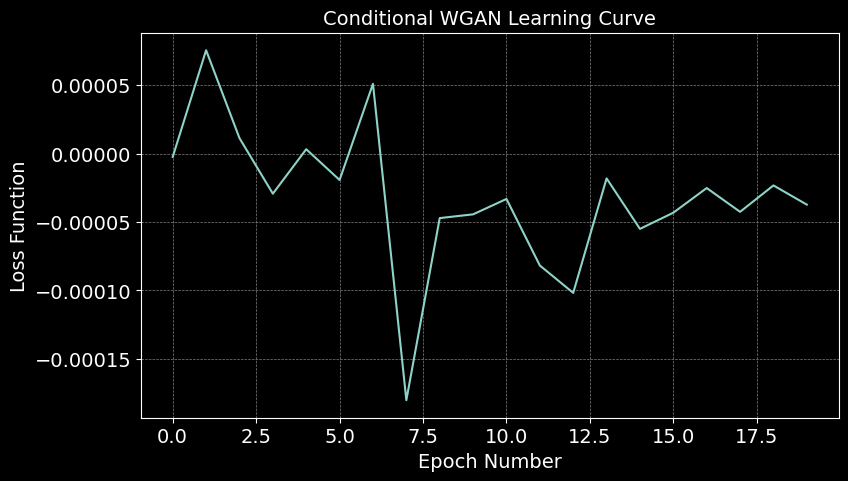

In [61]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(visible=True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [62]:
### YOUR CODE IS HERE ######

X_fake_train = generate(
    fitter.generator,
    torch.tensor(y_train, dtype=torch.float, device=DEVICE),
    latent_dim,
).cpu().detach().numpy()
X_fake_test = generate(
    fitter.generator,
    torch.tensor(y_test, dtype=torch.float, device=DEVICE),
    latent_dim,
).cpu().detach().numpy()
X_train_inv = quantile_transformer.inverse_transform(X_train)
X_test_inv = quantile_transformer.inverse_transform(X_test)
X_fake_train_inv = quantile_transformer.inverse_transform(X_fake_train)
X_fake_test_inv = quantile_transformer.inverse_transform(X_fake_test)

### THE END OF YOUR CODE ###

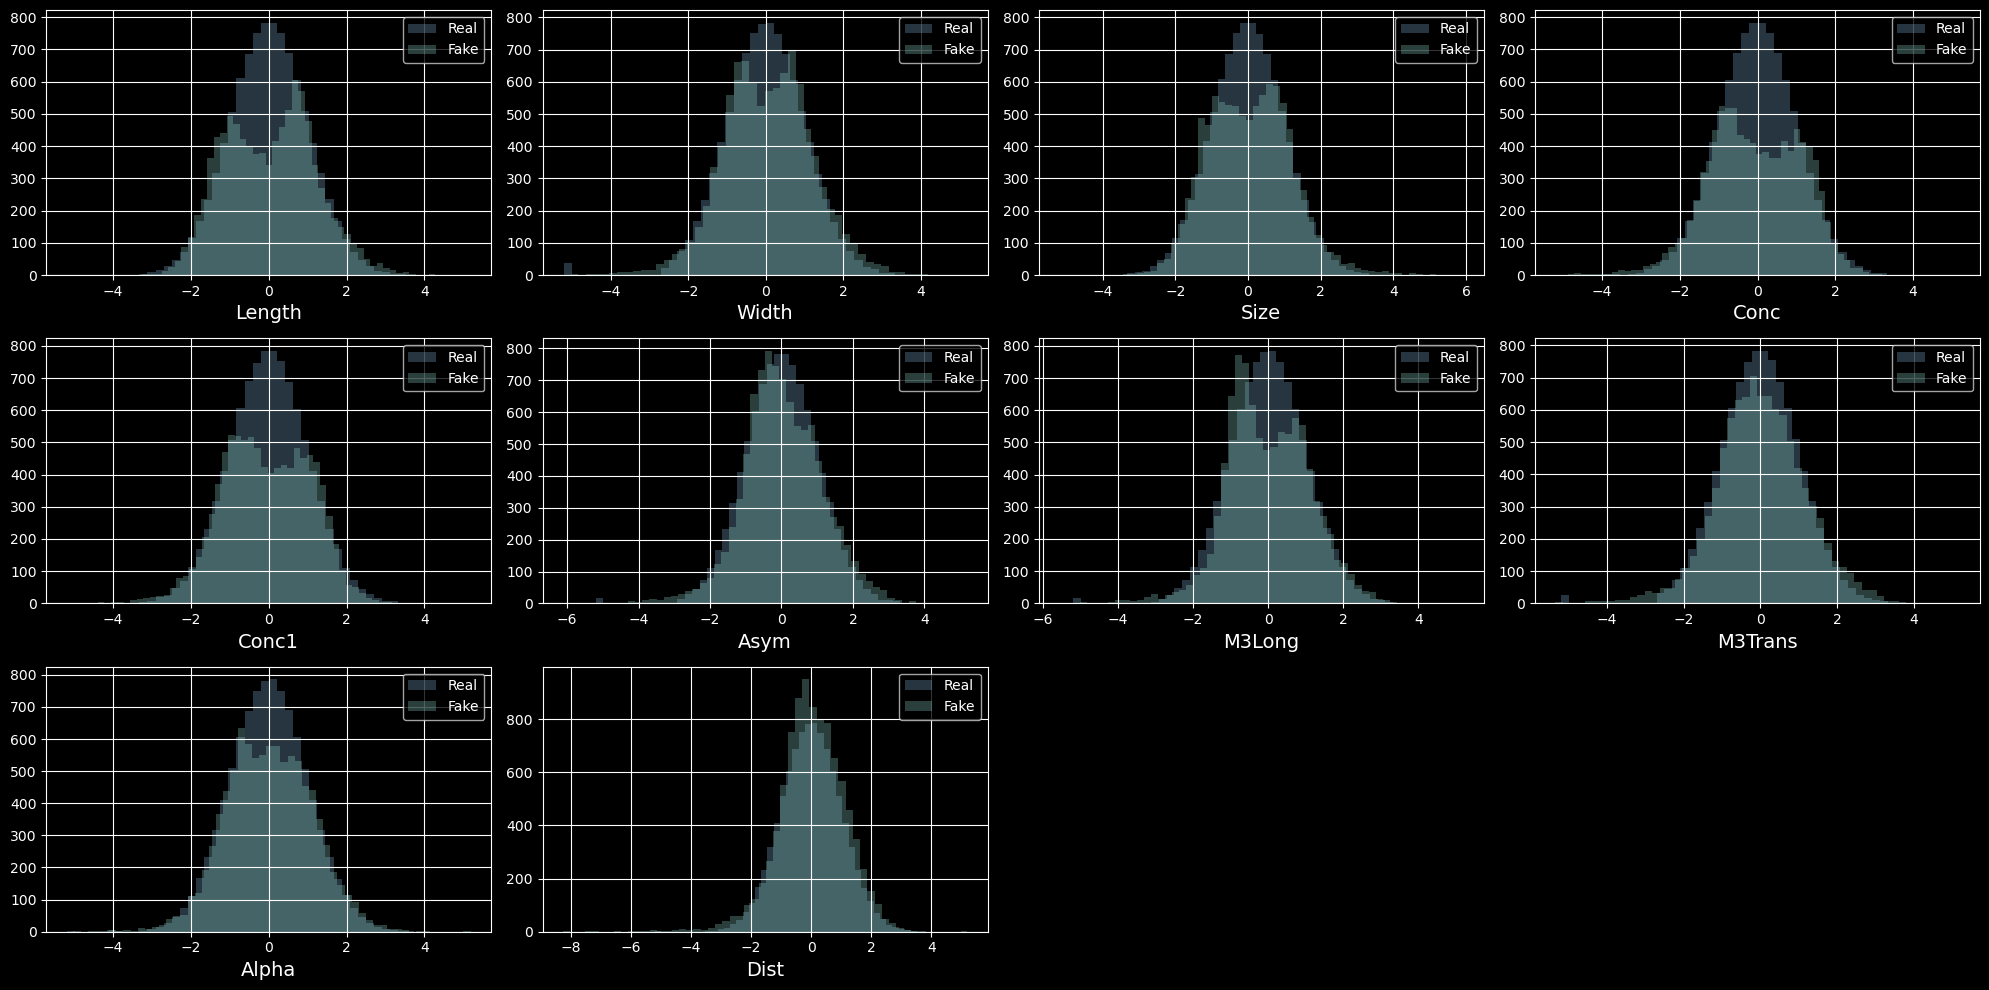

In [63]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

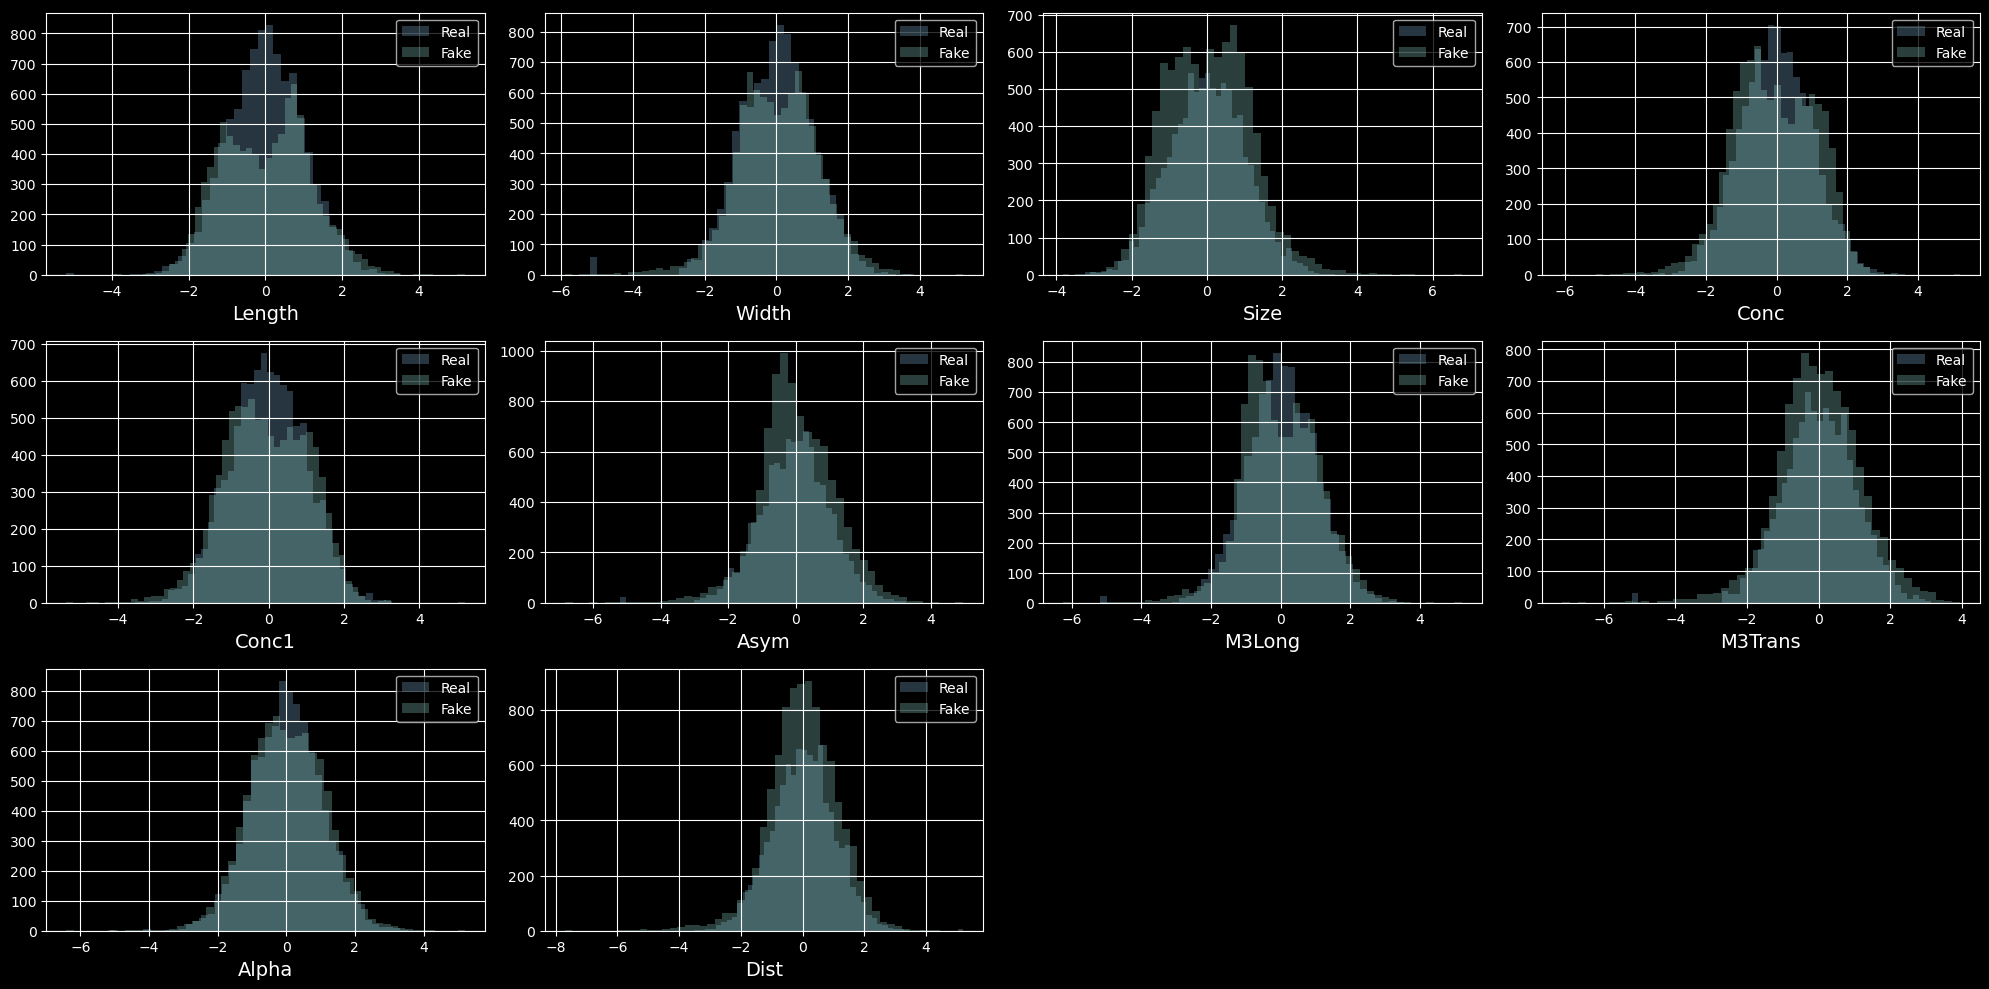

In [64]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Ответьте на вопросы: 
- Похожи ли фейковые объекты на реальные? 
- Точно ли хорошая идея сравнивать их на глаз?


Визуально фейковые объекты похожи на реальные.<br>
Нет, полагаться исключительно на визуальное сравнение не всегда корректно. Человеческое восприятие может не уловить тонких, но важных различий между распределениями. Поэтому для объективной оценки качества генерации стоит использовать количественные метрики, например, ROC AUC, сбалансированное качество классификатора или другие статистические показатели, которые помогут лучше оценить, насколько фейковые данные близки к реальным.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [65]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [67]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7436598312031941


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Очевидно, что хотелось бы увидеть ROC AUC близкий к 0.5, поскольку в таком случае наша модель не может отличить реальные объекты от фейковых.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Воспользуйтесь [DDPMScheduler](https://huggingface.co/docs/diffusers/api/schedulers/ddpm), возьмите 1000 шагов и подумайте, надо ли указать ещё какой-то параметр.

__Подсказка__: Посмотрите на распределения выше и почитайте описание шедулера в документации. Один из параметров - наследие от использования в генерации картинок, а у нас не картинки.

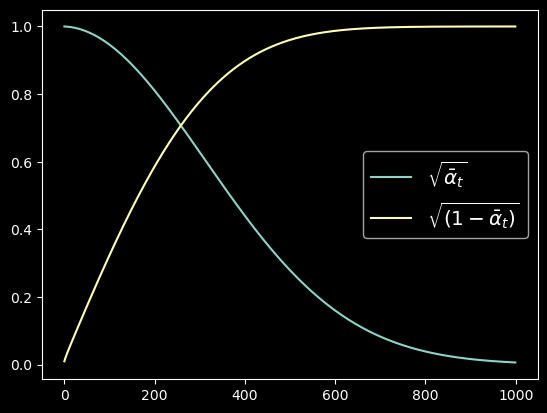

In [24]:
from diffusers import DDPMScheduler


noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=False)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качестве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [25]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden_dim=256, time_emb_dim=64):
        super(DiffusionGenerator, self).__init__()

        self.time_emb = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim * 2),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 2, time_emb_dim),
        )

        self.input_layer = nn.Linear(n_inputs + time_emb_dim, hidden_dim)

        self.blocks = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                    nn.SiLU(),
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                    nn.SiLU(),
                )
                for _ in range(4)
            ]
        )

        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, n_outputs),
        )

    def forward(self, z, t, y):
        t = t.unsqueeze(-1).float()
        t_emb = self.time_emb(t)

        x = torch.cat([z, t_emb, y], dim=-1)
        x = self.input_layer(x)

        for block in self.blocks:
            x = x + block(x)

        return self.output_layer(x)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [26]:
def generate_with_diffusion(model, y, latent_dim, scheduler, chunk_size=1000):
    total_samples = y.size(0)
    outputs = []

    # Process in chunks
    for i in tqdm(
        range(0, total_samples, chunk_size), desc="Generating samples"
    ):
        end_idx = min(i + chunk_size, total_samples)
        y_chunk = y[i:end_idx]

        x = torch.randn(len(y_chunk), latent_dim, device=DEVICE)

        # Reverse diffusion process
        for t in reversed(range(scheduler.config.num_train_timesteps)):
            t_tensor = torch.full(
                (len(y_chunk),), t, device=DEVICE, dtype=torch.long
            )

            with torch.no_grad():
                predicted_noise = model(x, t_tensor, y_chunk)
                step_result = scheduler.step(predicted_noise, t, x)
                x = step_result.prev_sample

        outputs.append(x.cpu())

    return torch.cat(outputs, dim=0)

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [27]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
    ):
        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr

        self.opt_gen = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.model.to(DEVICE)

    def fit(self, X, y):
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.opt_gen, self.n_epochs
        )

        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        dataset_real = TensorDataset(X_real, y_cond)

        self.model.train(True)

        self.loss_history = []

        progress_bar = tqdm(range(self.n_epochs), desc="Training")
        for epoch in progress_bar:
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(
                    dataset_real, batch_size=self.batch_size, shuffle=True
                )
            ):

                # Generate random timesteps.
                t = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps - 1,
                    (real_batch.shape[0],),
                    dtype=torch.long,
                    device=DEVICE,
                )

                # Generate noise and add it using the scheduler.
                noise = torch.randn_like(real_batch)
                X_noised = noise_scheduler.add_noise(real_batch, noise, t)
                predicted_noise = self.model(X_noised, t, cond_batch)
                loss = F.mse_loss(predicted_noise, noise)

                self.opt_gen.zero_grad()
                loss.backward()

                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(), max_norm=1.0
                )
                self.opt_gen.step()

                loss_epoch += loss.item()

            loss_epoch /= len(real_batch)

            progress_bar.set_postfix(
                loss=loss_epoch, lr=lr_scheduler.get_last_lr()
            )

            self.loss_history.append(loss_epoch)

            if (epoch + 1) % 200 == 0:
                indices = np.random.choice(len(y_cond), 1000, replace=False)
                X_fake = generate_with_diffusion(
                    self.model,
                    y_cond[indices],
                    self.latent_dim,
                    noise_scheduler,
                )
                other_agent_score(
                    X_real.cpu().detach().numpy(),
                    np.ones(len(X_real)),
                    X_fake.cpu().detach().numpy(),
                    np.zeros(len(X_fake)),
                )
            lr_scheduler.step()

        # Turn off training.
        self.model.train(False)

Обучим модель на данных, указав количество входов. 

У вас есть скрытое пространство и его размер, есть таймстепы и есть условие. Как легко догадаться, размер входа будет больше, чем просто размер скрытого пространства.

In [28]:
%%time
latent_dim = X_train.shape[1]

model = DiffusionGenerator(
    n_inputs=X_train.shape[1] + y_train.shape[1],
    n_outputs=X_train.shape[1],
    hidden_dim=256,
    time_emb_dim=64,
)

diffusion_fitter = DiffusionFitter(
    model,
    batch_size=128,
    n_epochs=50,
    latent_dim=latent_dim,
    lr=1e-3,
)
diffusion_fitter.fit(X_train, y_train)

Training: 100%|██████████| 50/50 [01:32<00:00,  1.84s/it, loss=0.38, lr=[9.866357858642206e-07]]  

CPU times: user 1min 24s, sys: 8.77 s, total: 1min 33s
Wall time: 1min 32s


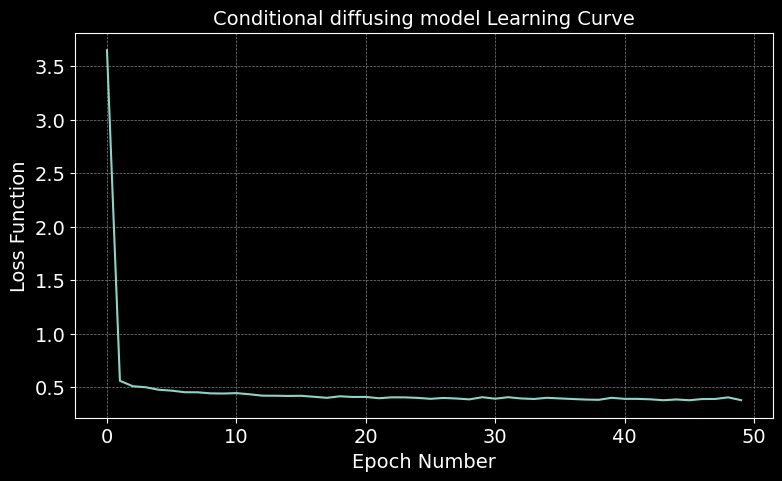

In [29]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusion_fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(visible=True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [30]:
X_fake_train = (
    generate_with_diffusion(
        diffusion_fitter.model,
        torch.tensor(y_train, dtype=torch.float, device=DEVICE),
        diffusion_fitter.latent_dim,
        noise_scheduler,
    )
    .cpu()
    .detach()
    .numpy()
)
X_fake_test = (
    generate_with_diffusion(
        diffusion_fitter.model,
        torch.tensor(y_test, dtype=torch.float, device=DEVICE),
        diffusion_fitter.latent_dim,
        noise_scheduler,
    )
    .cpu()
    .detach()
    .numpy()
)
X_train_inv = quantile_transformer.inverse_transform(X_train)
X_test_inv = quantile_transformer.inverse_transform(X_test)
X_fake_train_inv = quantile_transformer.inverse_transform(X_fake_train)
X_fake_test_inv = quantile_transformer.inverse_transform(X_fake_test)

Generating samples: 100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


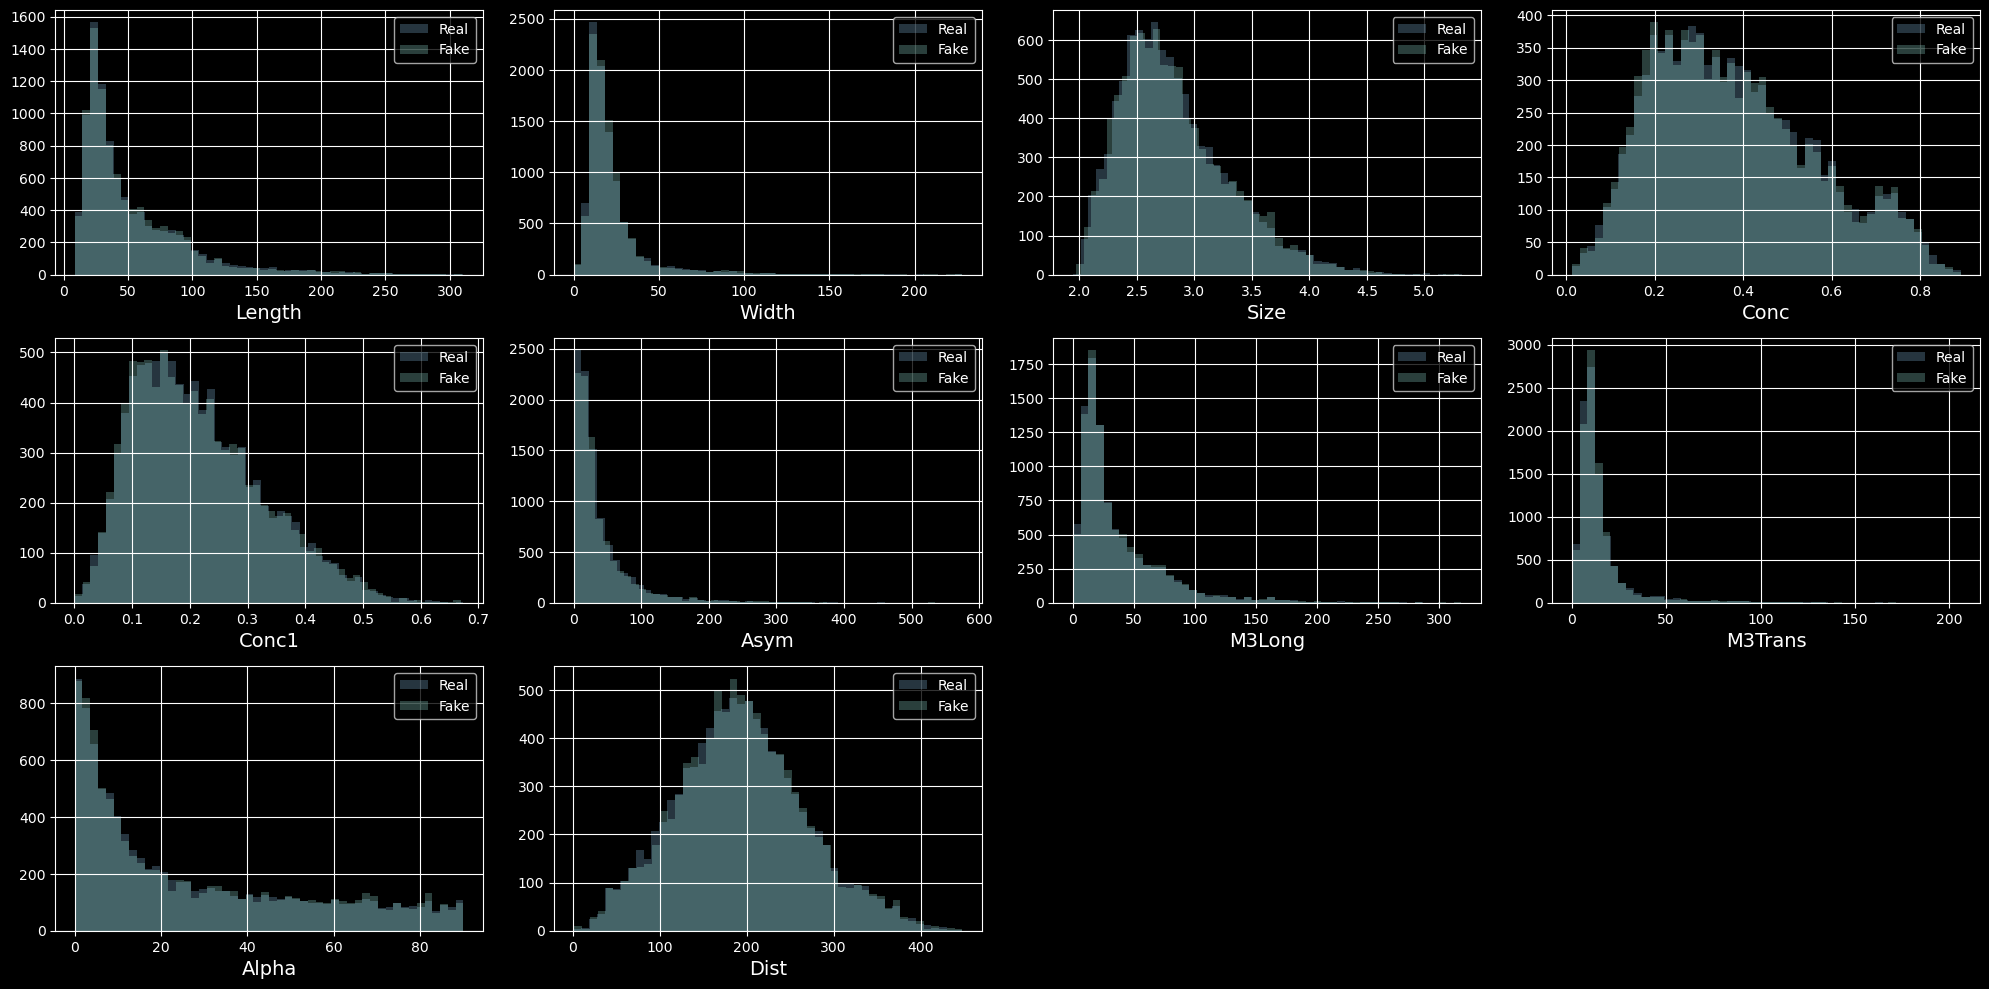

In [31]:
plot_hists(X_train_inv, X_fake_train_inv, names, label1="Real", label2="Fake", bins=50)

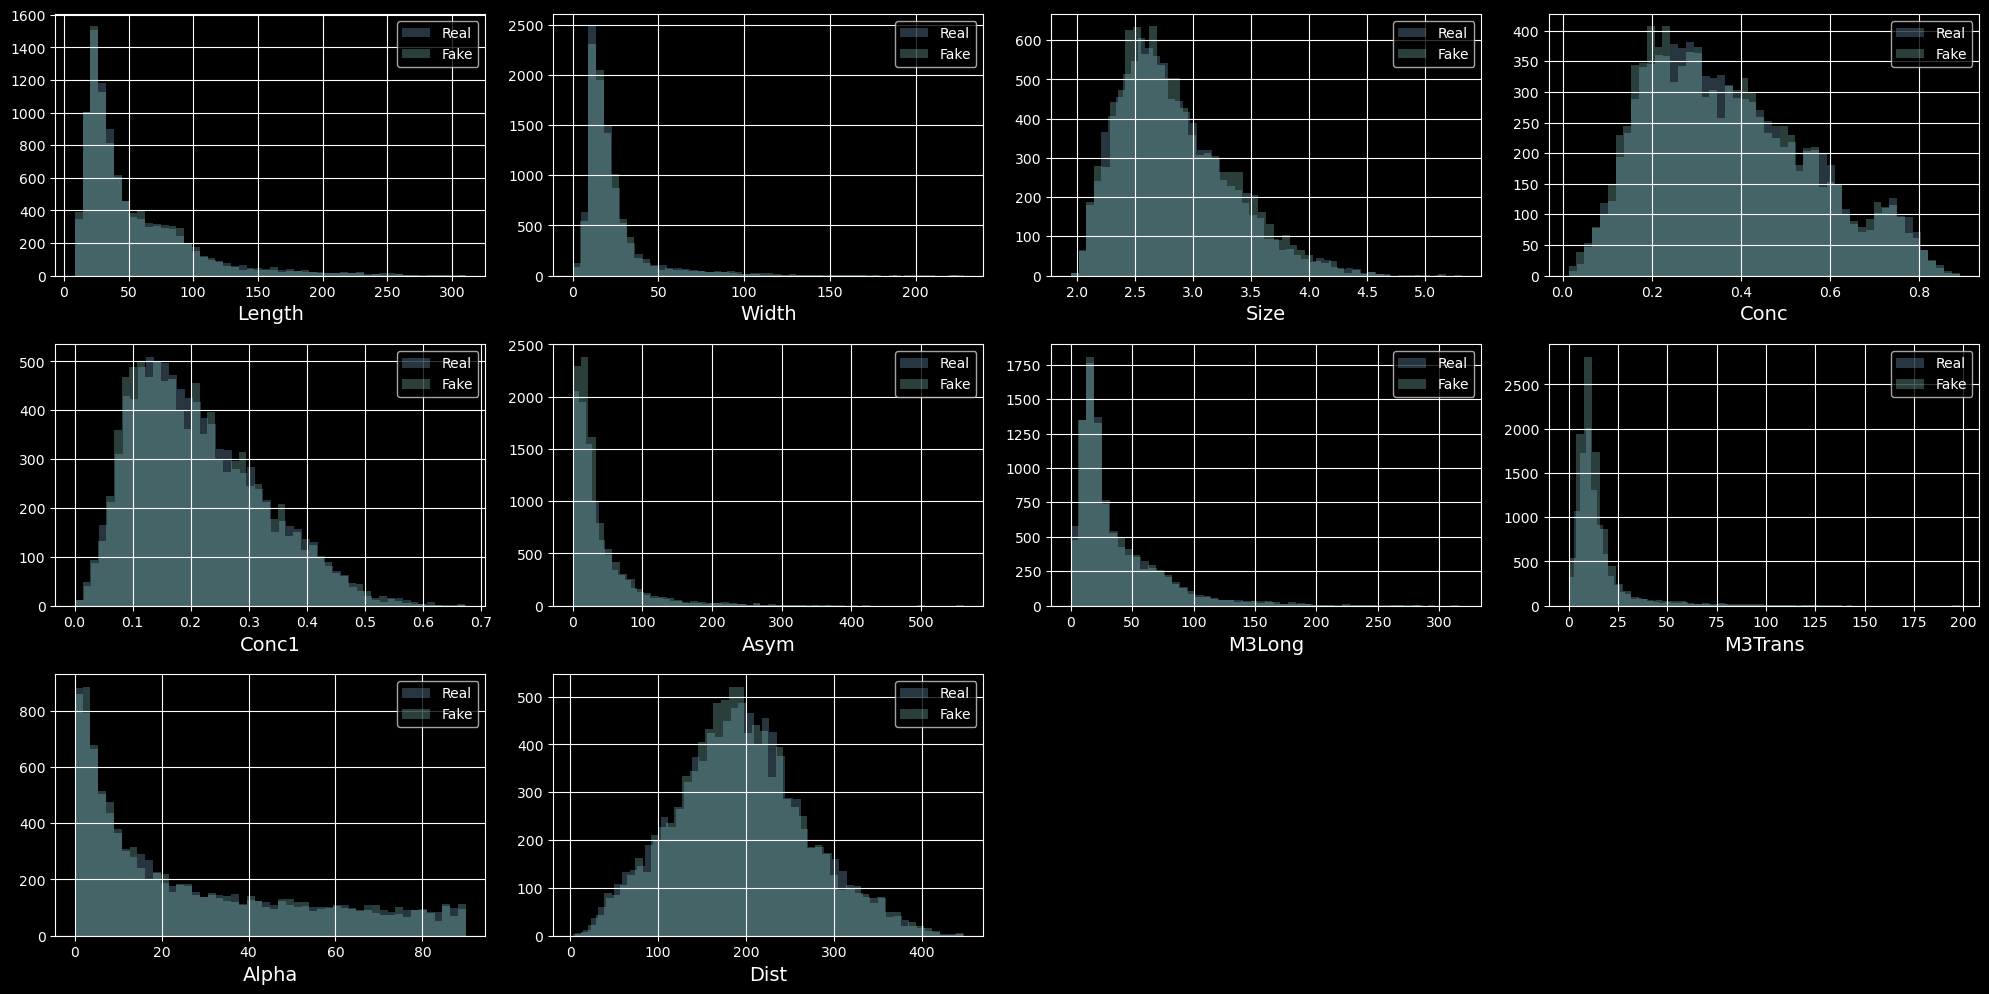

In [32]:
plot_hists(X_test_inv, X_fake_test_inv, names, label1="Real", label2="Fake", bins=50)

In [33]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [35]:
from sklearn.metrics import roc_auc_score

# считаем метрики
roc_auc = roc_auc_score(yy_test, yy_test_proba)

print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.6328


Результат прекрасный и с точки зрения ROC AUC, и с точки зрения распределений.

# Бонус (2 балла)

Кроме Diffusion и GAN вы изучили еще VAE и NF. В качестве бонуса релизуйте VAE, обучите, и в конце сравните качество теми же методами, что и в основной части ДЗ. 

Разбалловка бонуса такая:
- Реализовать VAE - 1 балл
- Обучить VAE - 0.5 балла
- Провести сравнение с GAN и Diffusion аналогично 14 заданию основной части - 0.5 балла

Ниже приведены шаблоны. Они не особо щедры на комментарии, но поскольку задача бонусная, ожидаем, что вы в них разберетесь. Если они вам не нравятся - можете переписать как хотите.

Если же VAE вам кажется слишком скучным, то мы засчитаем реализацию NF, но шаблонов не предоставим. Бонус в таком случае тоже ограничен сверху 2 баллами и разбалловка не изменится.

In [20]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()

        self.enc_net = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        
        self.mu = nn.Linear(128, lat_size)
        self.log_sigma = nn.Linear(128, lat_size)

    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma


class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()

        self.dec_net = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )

    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec
    
def generate(decoder, y, latent_dim):
    if not torch.is_tensor(y):
        y = torch.tensor(y, dtype=torch.float32, device=DEVICE)

    z = torch.randn(len(y), latent_dim, device=DEVICE)
    
    with torch.no_grad():
        X_fake = decoder(z, y)
    
    return X_fake

In [30]:
class VAEFitter(object):
    def __init__(
        self,
        encoder,
        decoder,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        KL_weight=0.001,
    ):

        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight

        self.criterion = nn.MSELoss()
        self.opt = torch.optim.RMSprop(
            list(self.encoder.parameters()) + list(self.decoder.parameters()),
            lr=self.lr,
        )

        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)

    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps

    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(
            -0.5 * torch.sum(1 + log_sigma - mu**2 - log_sigma.exp(), dim=1),
            dim=0,
        )
        recon_loss = self.criterion(x, rec_x)
        return KL * self.KL_weight + recon_loss

    def compute_loss(self, x_batch, cond_batch):
        mu, log_sigma = self.encoder(x_batch, cond_batch)

        z = self.sample_z(mu, log_sigma)

        x_reconstructed = self.decoder(z, cond_batch)

        loss = self.custom_loss(x_batch, x_reconstructed, mu, log_sigma)

        return loss

    def fit(self, X, y):
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.opt, T_0=self.n_epochs
        )

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)

        self.loss_history = []

        # Fit
        progress_bar = tqdm(range(self.n_epochs), desc="Training")
        for epoch in progress_bar:
            for i, (x_batch, cond_batch) in enumerate(
                DataLoader(
                    dataset_real, batch_size=self.batch_size, shuffle=True
                )
            ):

                # caiculate loss
                loss = self.compute_loss(x_batch, cond_batch)

                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()

            # caiculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())

            progress_bar.set_postfix(loss=loss_epoch.item())

            if (epoch + 1) % 100 == 0:
                indecies = np.random.choice(len(y_cond), 1000, replace=False)
                X_fake = generate(
                    self.decoder,
                    y_cond[indecies],
                    self.latent_dim,
                )
                other_agent_score(
                    X_real.cpu().detach().numpy(),
                    np.ones(len(X_real)),
                    X_fake.cpu().detach().numpy(),
                    np.zeros(len(X_fake)),
                )
            scheduler.step()

        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

In [43]:
latent_dim = 32
encoder = Encoder(n_inputs=X_train.shape[1] + y_train.shape[1], lat_size=latent_dim)
decoder = Decoder(n_inputs=latent_dim + y_train.shape[1], n_outputs=X_train.shape[1])

vaeFitter = VAEFitter(
    encoder,
    decoder,
    batch_size=64,
    n_epochs=50,
    latent_dim=latent_dim,
    lr=1e-3,
    KL_weight=0.001
)

vaeFitter.fit(X_train, y_train)

Training: 100%|██████████| 50/50 [01:11<00:00,  1.44s/it, loss=0.0285]


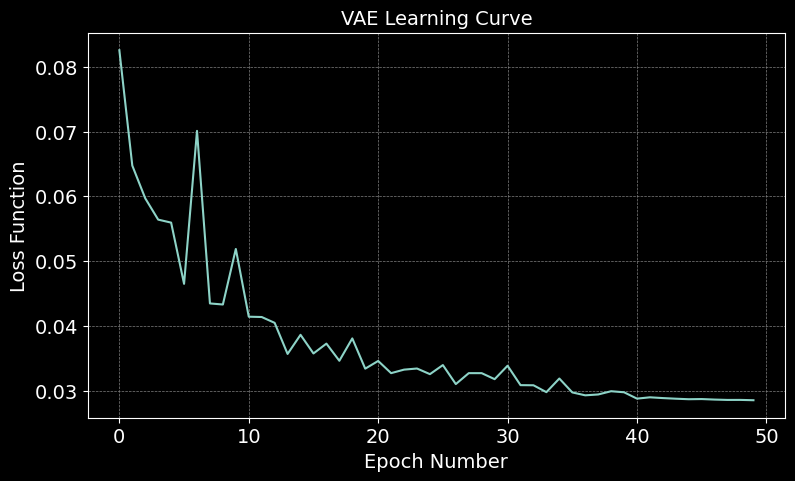

In [44]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(vaeFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("VAE Learning Curve", size=14)
plt.grid(visible=True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

In [45]:
X_fake_train = generate(vaeFitter.decoder, y_train, vaeFitter.latent_dim).cpu().detach().numpy()
X_fake_test = generate(vaeFitter.decoder, y_test, vaeFitter.latent_dim).cpu().detach().numpy()

X_train_inv = quantile_transformer.inverse_transform(X_train)
X_test_inv = quantile_transformer.inverse_transform(X_test)
X_fake_train_inv = quantile_transformer.inverse_transform(X_fake_train)
X_fake_test_inv = quantile_transformer.inverse_transform(X_fake_test)

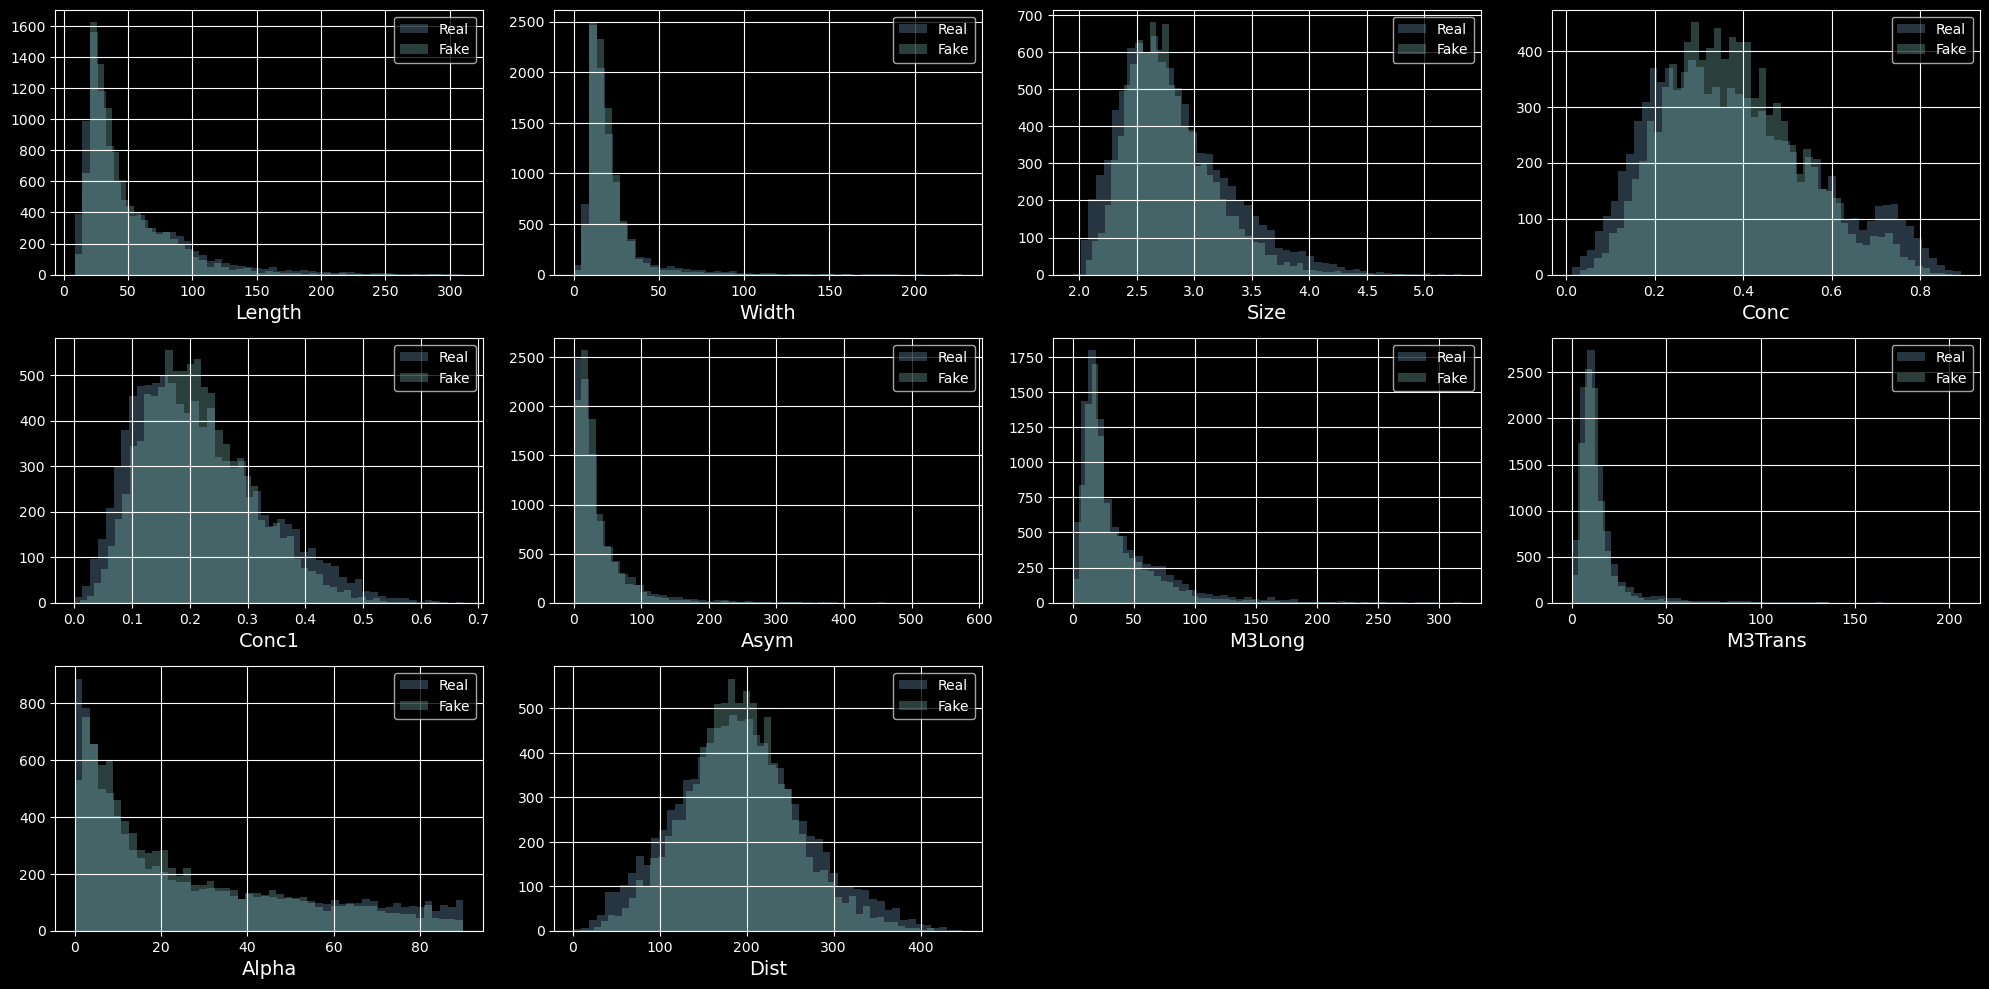

In [46]:
plot_hists(X_train_inv, X_fake_train_inv, names, label1="Real", label2="Fake", bins=50)

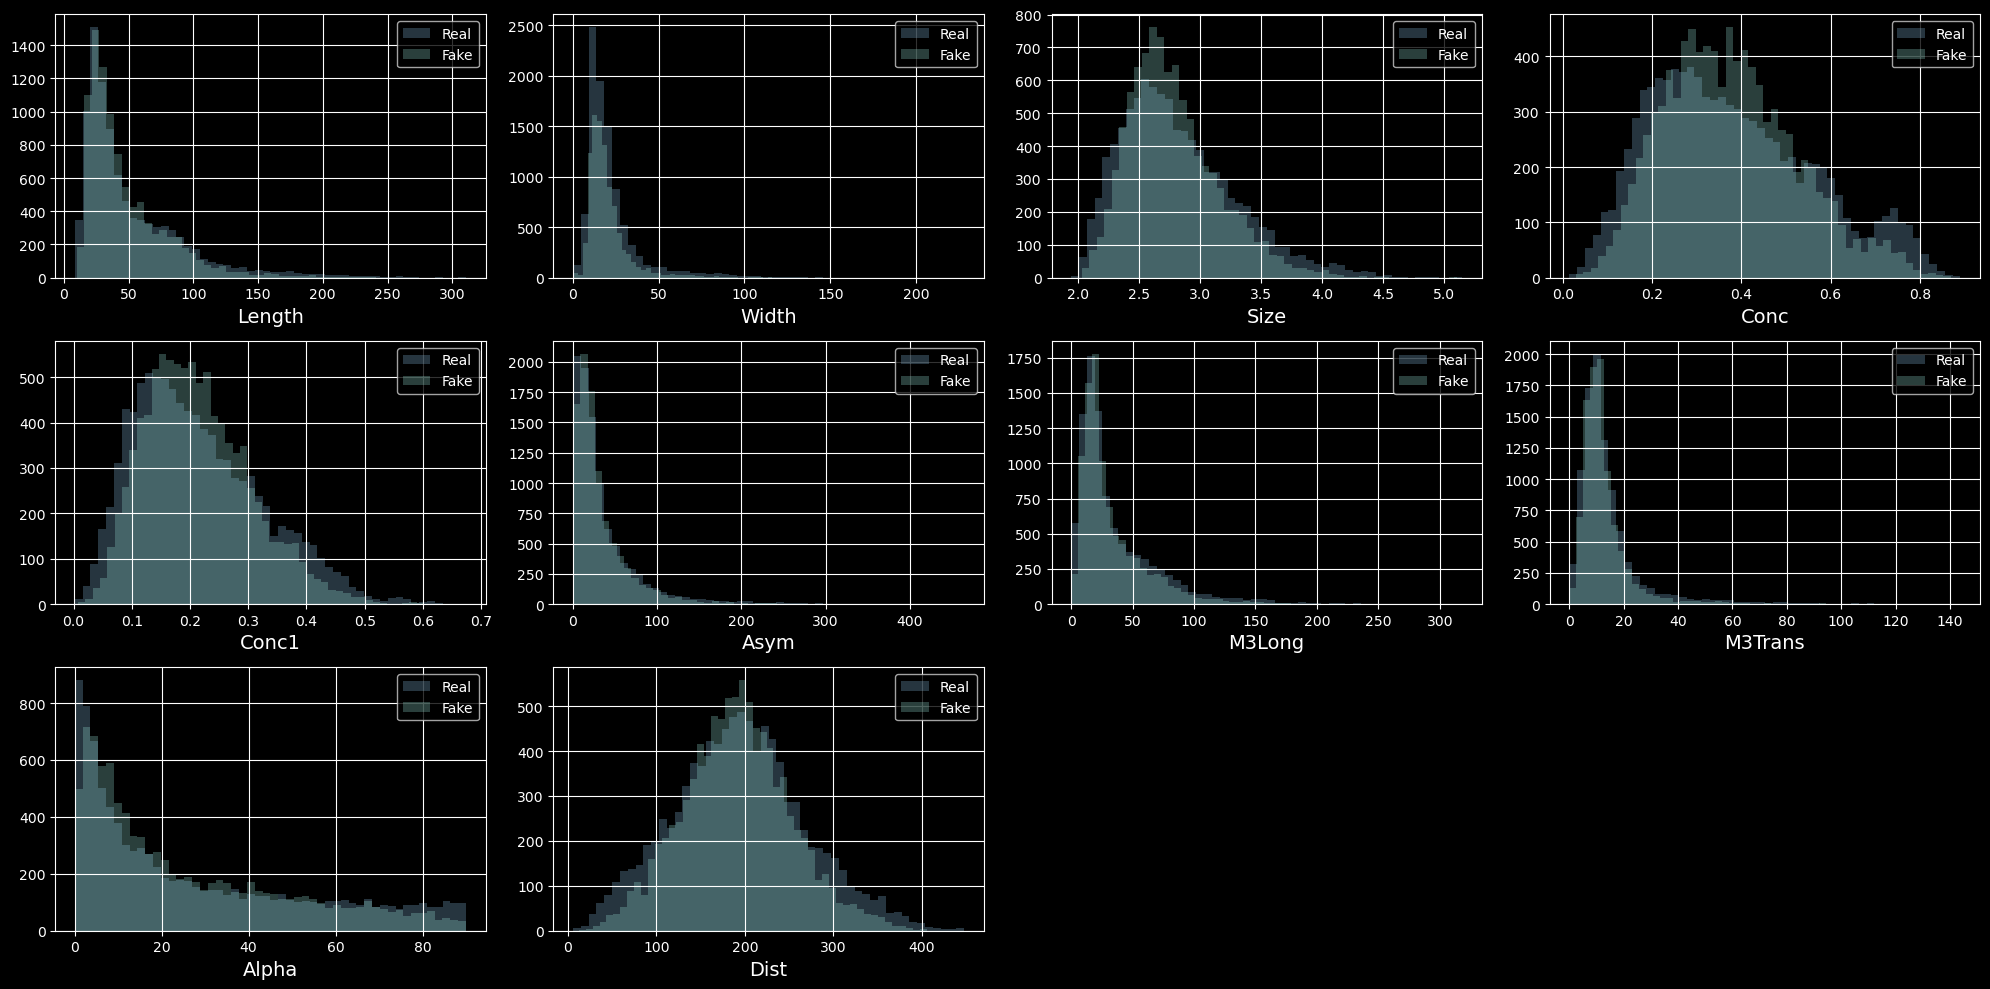

In [47]:
plot_hists(X_test_inv, X_fake_test_inv, names, label1="Real", label2="Fake", bins=50)

In [48]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [50]:
from sklearn.metrics import roc_auc_score

# считаем метрики
roc_auc = roc_auc_score(yy_test, yy_test_proba)

print(f"ROC-AUC: {roc_auc:.4f}")

ROC-AUC: 0.7176


Результаты VAE тоже достаточно неплохие.

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!